Num GPUs Available:  2


100%|██████████| 82/82 [00:33<00:00,  2.48it/s]


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 88s 579ms/step - accuracy: 0.0153 - loss: 11.8372 - val_accuracy: 0.0528 - val_loss: 9.3403 - learning_rate: 1.0000e-04
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 53s 481ms/step - accuracy: 0.0499 - loss: 8.7802 - val_accuracy: 0.1067 - val_loss: 7.3224 - learning_rate: 1.0000e-04
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 507ms/step - accuracy: 0.0905 - loss: 6.9554 - val_accuracy: 0.1521 - val_loss: 6.0798 - learning_rate: 1.0000e-04
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 55s 499ms/step - accuracy: 0.1334 - loss: 5.8378 - val_accuracy: 0.1669 - val_loss: 5.3164 - learning_rate: 1.0000e-04
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 515ms/step - accuracy: 0.1536 - loss: 5.1588 - val_accuracy: 0.2025 - val_loss: 4.8376 - learning_rate: 1.0000e-04
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 515ms/step - accuracy: 0.2011 - loss: 4.7104 - val_accuracy: 0.2368 - val_loss: 4.5195 - learning_rate: 1.0

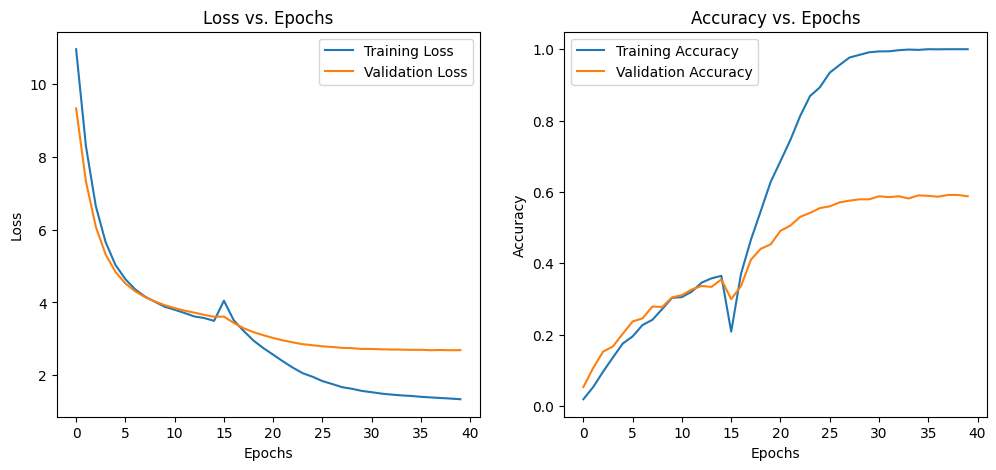

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check for GPUs and setup mirrored strategy
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
strategy = tf.distribute.MirroredStrategy()

# Dataset Path for Kaggle
dataset_folder = '/kaggle/input/isolated-words-per-user/isolated_words_per_user'
data = []

# Load Dataset
for user_folder in tqdm(sorted(os.listdir(dataset_folder))):
    user_path = os.path.join(dataset_folder, user_folder)
    if not os.path.isdir(user_path):
        continue
    label = int(user_folder.replace('user', '')) - 1  # Convert user ID to 0-indexed label
    for image_name in os.listdir(user_path):
        image_path = os.path.join(user_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image_resized = cv2.resize(image, (224, 224))  # Resize to 224x224
            image_normalized = image_resized.astype('float32') / 255.0  # Normalize to [0, 1]
            data.append((image_normalized, label))

# Convert to numpy arrays
images, labels = zip(*data)
images = np.array(images).reshape(-1, 224, 224, 1)  # Add channel dimension
labels = np.array(labels)

# Split into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_one_hot = encoder.transform(test_labels.reshape(-1, 1))

# Convert grayscale to RGB by repeating channels
train_images_rgb = np.repeat(train_images, 3, axis=-1)
test_images_rgb = np.repeat(test_images, 3, axis=-1)

# Create TensorFlow Datasets for consistency across GPUs
BATCH_SIZE = 64
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images_rgb, train_labels_one_hot))
    .shuffle(buffer_size=1024)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_images_rgb, test_labels_one_hot))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Define the Model within the Strategy Scope
with strategy.scope():
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze all layers initially

    # Add Custom Layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    output = Dense(len(np.unique(labels)), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the Model
    optimizer = Adam(learning_rate=1e-4)
    loss = CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train Fully Connected Layers Only
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ],
)

# Unfreeze the Top Layers for Fine-Tuning
with strategy.scope():
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    # Recompile the Model for Fine-Tuning
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=loss, metrics=['accuracy'])

# Fine-Tune the Model
fine_tune_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ],
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Fine-Tuned Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the Model
model.save('/kaggle/working/fine_tuned_resnet152v2.h5')

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm

# Dataset path for Kaggle
dataset_folder = '/kaggle/input/isolated-words-per-user/isolated_words_per_user'

# Dictionary to store images and labels (image, user_id)
train_data = []  # To store tuples (image, label)
test_data = []  # To store tuples (image, label)

# Traverse each user folder
for user_folder in tqdm(sorted(os.listdir(dataset_folder))):
    user_path = os.path.join(dataset_folder, user_folder)

    # Skip if not a directory
    if not os.path.isdir(user_path):
        continue

    label = int(user_folder.replace('user', ''))  # Extract user ID

    # Dictionary to group images by words for the user
    word_to_images = {}

    # Read all images in the folder
    for image_name in os.listdir(user_path):
        image_path = os.path.join(user_path, image_name)
        # Extract the word from the filename (assuming format userXXX_word_index.png)
        word = image_name.split('_')[1]  # Extract word part (e.g., "abjadiyah" from "user001_abjadiyah_031.png")

        # Read the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            # Resize and normalize image
            image_resized = cv2.resize(image, (128, 128)).astype('float32') / 255.0

            # Group by words
            if word not in word_to_images:
                word_to_images[word] = []
            word_to_images[word].append((image_resized, label))
        else:
            print(f"Warning: Unable to read {image_path}")

    # Split words into training and testing
    words = list(word_to_images.keys())
    random.shuffle(words)
    train_words = words[:8]  # 8 words for training
    test_words = words[8:]  # 2 words for testing

    # Add images from the chosen words to train and test sets
    for word in train_words:
        train_data.extend(word_to_images[word])

    for word in test_words:
        test_data.extend(word_to_images[word])

# Convert data to numpy arrays
train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)

train_images = np.array(train_images).reshape(-1, 128, 128, 1)  # Add channel dimension for grayscale
train_labels = np.array(train_labels) - 1  # Convert labels to 0-indexed
test_images = np.array(test_images).reshape(-1, 128, 128, 1)
test_labels = np.array(test_labels) - 1  # Convert labels to 0-indexed

print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Testing set: {test_images.shape}, Labels: {test_labels.shape}")

# Save numpy arrays for later use
np.save('/kaggle/working/train_images.npy', train_images)
np.save('/kaggle/working/train_labels.npy', train_labels)
np.save('/kaggle/working/test_images.npy', test_images)
np.save('/kaggle/working/test_labels.npy', test_labels)


100%|██████████| 82/82 [00:24<00:00,  3.30it/s]


Training set: (6524, 128, 128, 1), Labels: (6524,)
Testing set: (1620, 128, 128, 1), Labels: (1620,)


Device: cuda
Available GPUs: 2
Loading preprocessed data files...
Data loaded successfully!
Preparing datasets and data loaders...
Model initialized with 82 classes. Using 2 GPUs.
Starting model training...


Epoch 1/30: 100%|██████████| 102/102 [00:22<00:00,  4.50it/s]


Epoch 1/30 | Train Loss: 4.4350, Train Acc: 1.53% | Val Loss: 4.3884, Val Acc: 1.85%


Epoch 2/30: 100%|██████████| 102/102 [00:22<00:00,  4.46it/s]


Epoch 2/30 | Train Loss: 4.2926, Train Acc: 2.21% | Val Loss: 4.9879, Val Acc: 2.41%


Epoch 3/30: 100%|██████████| 102/102 [00:23<00:00,  4.32it/s]


Epoch 3/30 | Train Loss: 4.1108, Train Acc: 3.66% | Val Loss: 4.6545, Val Acc: 3.58%


Epoch 4/30: 100%|██████████| 102/102 [00:23<00:00,  4.43it/s]


Epoch 4/30 | Train Loss: 3.9394, Train Acc: 6.47% | Val Loss: 4.1419, Val Acc: 6.54%


Epoch 5/30: 100%|██████████| 102/102 [00:22<00:00,  4.46it/s]


Epoch 5/30 | Train Loss: 3.7580, Train Acc: 9.14% | Val Loss: 4.2029, Val Acc: 6.36%


Epoch 6/30: 100%|██████████| 102/102 [00:23<00:00,  4.33it/s]


Epoch 6/30 | Train Loss: 3.5142, Train Acc: 11.25% | Val Loss: 4.1991, Val Acc: 9.51%


Epoch 7/30: 100%|██████████| 102/102 [00:22<00:00,  4.50it/s]


Epoch 7/30 | Train Loss: 3.3435, Train Acc: 13.64% | Val Loss: 3.7196, Val Acc: 12.16%


Epoch 8/30: 100%|██████████| 102/102 [00:22<00:00,  4.45it/s]


Epoch 8/30 | Train Loss: 3.1756, Train Acc: 16.42% | Val Loss: 3.1338, Val Acc: 17.84%


Epoch 9/30: 100%|██████████| 102/102 [00:24<00:00,  4.24it/s]


Epoch 9/30 | Train Loss: 2.9596, Train Acc: 20.00% | Val Loss: 3.2781, Val Acc: 19.07%


Epoch 10/30: 100%|██████████| 102/102 [00:24<00:00,  4.21it/s]


Epoch 10/30 | Train Loss: 2.7985, Train Acc: 22.81% | Val Loss: 3.0309, Val Acc: 20.56%


Epoch 11/30: 100%|██████████| 102/102 [00:23<00:00,  4.30it/s]


Epoch 11/30 | Train Loss: 2.5795, Train Acc: 28.45% | Val Loss: 3.8546, Val Acc: 16.98%


Epoch 12/30: 100%|██████████| 102/102 [00:22<00:00,  4.44it/s]


Epoch 12/30 | Train Loss: 2.4030, Train Acc: 31.02% | Val Loss: 2.7326, Val Acc: 28.89%


Epoch 13/30: 100%|██████████| 102/102 [00:22<00:00,  4.50it/s]


Epoch 13/30 | Train Loss: 2.2072, Train Acc: 36.22% | Val Loss: 2.2925, Val Acc: 36.11%


Epoch 14/30: 100%|██████████| 102/102 [00:22<00:00,  4.44it/s]


Epoch 14/30 | Train Loss: 2.0562, Train Acc: 39.41% | Val Loss: 2.9746, Val Acc: 30.12%


Epoch 15/30: 100%|██████████| 102/102 [00:23<00:00,  4.29it/s]


Epoch 15/30 | Train Loss: 1.8842, Train Acc: 43.59% | Val Loss: 2.1854, Val Acc: 41.11%


Epoch 16/30: 100%|██████████| 102/102 [00:22<00:00,  4.44it/s]


Epoch 16/30 | Train Loss: 1.7392, Train Acc: 47.41% | Val Loss: 2.4204, Val Acc: 38.46%


Epoch 17/30: 100%|██████████| 102/102 [00:22<00:00,  4.44it/s]


Epoch 17/30 | Train Loss: 1.5889, Train Acc: 52.54% | Val Loss: 1.7634, Val Acc: 49.88%


Epoch 18/30: 100%|██████████| 102/102 [00:23<00:00,  4.29it/s]


Epoch 18/30 | Train Loss: 1.4433, Train Acc: 56.10% | Val Loss: 2.1963, Val Acc: 43.95%


Epoch 19/30: 100%|██████████| 102/102 [00:22<00:00,  4.50it/s]


Epoch 19/30 | Train Loss: 1.2575, Train Acc: 60.73% | Val Loss: 1.5099, Val Acc: 58.95%


Epoch 20/30: 100%|██████████| 102/102 [00:23<00:00,  4.30it/s]


Epoch 20/30 | Train Loss: 1.1303, Train Acc: 65.14% | Val Loss: 1.2809, Val Acc: 65.68%


Epoch 21/30: 100%|██████████| 102/102 [00:23<00:00,  4.42it/s]


Epoch 21/30 | Train Loss: 0.9865, Train Acc: 68.90% | Val Loss: 1.3288, Val Acc: 64.88%


Epoch 22/30: 100%|██████████| 102/102 [00:23<00:00,  4.32it/s]


Epoch 22/30 | Train Loss: 0.8350, Train Acc: 73.34% | Val Loss: 1.1275, Val Acc: 71.48%


Epoch 23/30: 100%|██████████| 102/102 [00:22<00:00,  4.44it/s]


Epoch 23/30 | Train Loss: 0.7356, Train Acc: 76.53% | Val Loss: 1.1021, Val Acc: 72.59%


Epoch 24/30: 100%|██████████| 102/102 [00:22<00:00,  4.44it/s]


Epoch 24/30 | Train Loss: 0.5977, Train Acc: 81.79% | Val Loss: 1.2698, Val Acc: 71.60%


Epoch 25/30: 100%|██████████| 102/102 [00:22<00:00,  4.48it/s]


Epoch 25/30 | Train Loss: 0.5180, Train Acc: 83.71% | Val Loss: 0.9802, Val Acc: 79.51%


Epoch 26/30: 100%|██████████| 102/102 [00:22<00:00,  4.45it/s]


Epoch 26/30 | Train Loss: 0.4172, Train Acc: 87.02% | Val Loss: 0.9447, Val Acc: 79.88%


Epoch 27/30: 100%|██████████| 102/102 [00:23<00:00,  4.32it/s]


Epoch 27/30 | Train Loss: 0.3207, Train Acc: 90.68% | Val Loss: 0.9252, Val Acc: 81.79%


Epoch 28/30: 100%|██████████| 102/102 [00:22<00:00,  4.45it/s]


Epoch 28/30 | Train Loss: 0.2848, Train Acc: 91.72% | Val Loss: 0.9350, Val Acc: 82.41%


Epoch 29/30: 100%|██████████| 102/102 [00:23<00:00,  4.30it/s]


Epoch 29/30 | Train Loss: 0.2727, Train Acc: 92.24% | Val Loss: 0.9010, Val Acc: 82.47%


Epoch 30/30: 100%|██████████| 102/102 [00:22<00:00,  4.45it/s]


Epoch 30/30 | Train Loss: 0.2485, Train Acc: 93.04% | Val Loss: 0.8960, Val Acc: 82.90%
Plotting training and validation results...


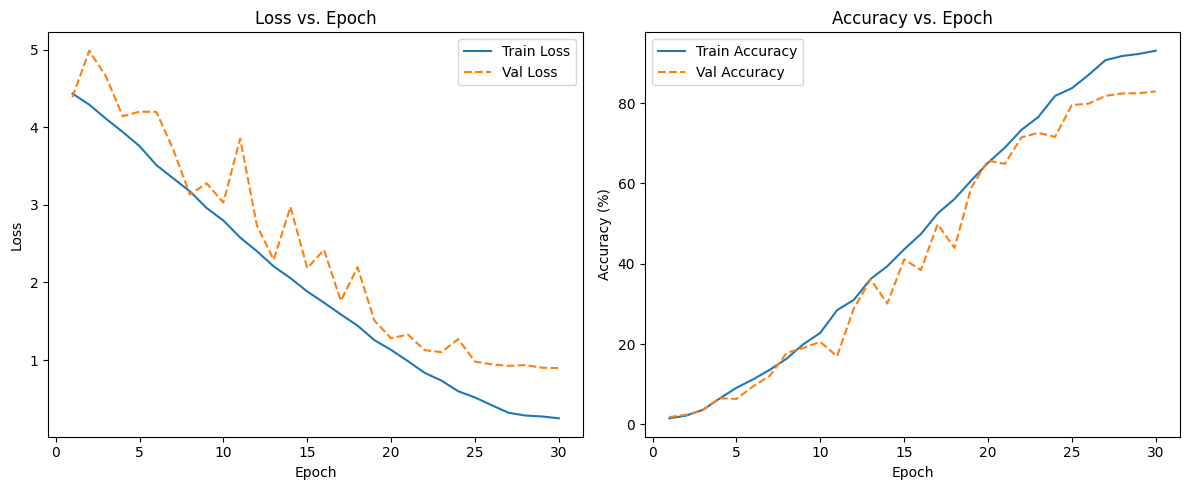

Evaluating the model...
Test Accuracy: 82.90%


In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fancy Printing
def fancy_print(message):
    print("\033[1;34m" + message + "\033[0m")

# Check GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fancy_print(f"Device: {device}")
fancy_print(f"Available GPUs: {torch.cuda.device_count()}")

# Load preprocessed data
fancy_print("Loading preprocessed data files...")
train_images = np.load('/kaggle/working/train_images.npy')
train_labels = np.load('/kaggle/working/train_labels.npy')
test_images = np.load('/kaggle/working/test_images.npy')
test_labels = np.load('/kaggle/working/test_labels.npy')

# Normalize labels
train_labels = train_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)
fancy_print("Data loaded successfully!")

# Dataset class for PyTorch
class ArabicWordDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.data_images = images
        self.data_labels = labels
        self.data_transform = transform

    def __len__(self):
        return len(self.data_images)

    def __getitem__(self, idx):
        image = self.data_images[idx]
        label = self.data_labels[idx]
        image = image.squeeze()  # Remove channel dim for grayscale

        if self.data_transform:
            image = self.data_transform(image)

        return image, label

# Define transforms for augmentation
augmentation_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10, scale=(0.999, 1.001)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmentation_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets and loaders
fancy_print("Preparing datasets and data loaders...")
training_dataset = ArabicWordDataset(train_images, train_labels, transform=augmentation_train)
testing_dataset = ArabicWordDataset(test_images, test_labels, transform=augmentation_test)

batch_size = 64
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

# Model definition
class ResNet101Arabic(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101Arabic, self).__init__()
        self.base_model = models.resnet101(weights=None)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adapt for grayscale
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Instantiate the model and wrap it with DataParallel
num_classes = len(np.unique(train_labels))
model = ResNet101Arabic(num_classes).to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)  # Use all available GPUs
fancy_print(f"Model initialized with {num_classes} classes. Using {torch.cuda.device_count()} GPUs.")

# Training function
def train_resnet(model, train_loader, test_loader, num_epochs=30, max_lr=1e-3):
    optimizer = optim.AdamW(model.parameters(), lr=max_lr, weight_decay=1e-4)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=num_epochs)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    train_loss_history, train_accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_preds = 0.0, 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", colour="blue"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                predictions = model(images)
                loss = criterion(predictions, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_loss += loss.item()
            correct_preds += (predictions.argmax(1) == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100.0 * correct_preds / len(train_loader.dataset)

        train_loss_history.append(avg_train_loss)
        train_accuracy_history.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in testing_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    predictions = model(images)
                    loss = criterion(predictions, labels)
                    val_loss += loss.item()
                    val_correct += (predictions.argmax(1) == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = 100.0 * val_correct / len(test_loader.dataset)

        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(val_accuracy)

        fancy_print(f"Epoch {epoch+1}/{num_epochs} | "
                    f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
                    f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

# Train the model
fancy_print("Starting model training...")
train_losses, train_accuracies, val_losses, val_accuracies = train_resnet(
    model, training_loader, testing_loader, num_epochs=30
)

# Plot training and validation results
fancy_print("Plotting training and validation results...")
plt.figure(figsize=(12, 5))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 31), train_losses, label="Train Loss")
plt.plot(range(1, 31), val_losses, label="Val Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 31), train_accuracies, label="Train Accuracy")
plt.plot(range(1, 31), val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
def evaluate_resnet(model, test_loader):
    model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
            correct_predictions += (outputs.argmax(1) == labels).sum().item()

    accuracy = 100 * correct_predictions / len(test_loader.dataset)
    fancy_print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate
fancy_print("Evaluating the model...")
evaluate_resnet(model, testing_loader)


Device: cuda
Available GPUs: 2
Loading preprocessed data files...
Data loaded successfully!
Preparing datasets and data loaders...
Model initialized with ResNet101 and 82 classes. Using 2 GPUs.
Starting model training (Fine-Tuning)...


Epoch 1/30: 100%|██████████| 102/102 [00:15<00:00,  6.53it/s]


Epoch 1/30 | Train Loss: 4.4018, Train Acc: 1.52% | Val Loss: 4.3820, Val Acc: 3.89%


Epoch 2/30: 100%|██████████| 102/102 [00:15<00:00,  6.56it/s]


Epoch 2/30 | Train Loss: 4.3513, Train Acc: 4.08% | Val Loss: 4.3066, Val Acc: 12.47%


Epoch 3/30: 100%|██████████| 102/102 [00:15<00:00,  6.67it/s]


Epoch 3/30 | Train Loss: 4.1756, Train Acc: 7.42% | Val Loss: 4.0372, Val Acc: 19.44%


Epoch 4/30: 100%|██████████| 102/102 [00:16<00:00,  6.30it/s]


Epoch 4/30 | Train Loss: 3.8066, Train Acc: 12.98% | Val Loss: 3.5425, Val Acc: 25.19%


Epoch 5/30: 100%|██████████| 102/102 [00:15<00:00,  6.61it/s]


Epoch 5/30 | Train Loss: 3.4380, Train Acc: 17.63% | Val Loss: 3.1357, Val Acc: 33.52%


Epoch 6/30: 100%|██████████| 102/102 [00:16<00:00,  6.32it/s]


Epoch 6/30 | Train Loss: 3.1183, Train Acc: 24.19% | Val Loss: 2.7814, Val Acc: 38.89%


Epoch 7/30: 100%|██████████| 102/102 [00:15<00:00,  6.58it/s]


Epoch 7/30 | Train Loss: 2.8674, Train Acc: 27.70% | Val Loss: 2.4798, Val Acc: 47.47%


Epoch 8/30: 100%|██████████| 102/102 [00:15<00:00,  6.40it/s]


Epoch 8/30 | Train Loss: 2.6379, Train Acc: 32.48% | Val Loss: 2.3329, Val Acc: 53.83%


Epoch 9/30: 100%|██████████| 102/102 [00:15<00:00,  6.57it/s]


Epoch 9/30 | Train Loss: 2.4948, Train Acc: 36.14% | Val Loss: 2.0343, Val Acc: 60.00%


Epoch 10/30: 100%|██████████| 102/102 [00:15<00:00,  6.69it/s]


Epoch 10/30 | Train Loss: 2.2714, Train Acc: 41.20% | Val Loss: 1.7785, Val Acc: 64.32%


Epoch 11/30: 100%|██████████| 102/102 [00:15<00:00,  6.58it/s]


Epoch 11/30 | Train Loss: 2.1180, Train Acc: 43.84% | Val Loss: 1.5932, Val Acc: 68.27%


Epoch 12/30: 100%|██████████| 102/102 [00:15<00:00,  6.60it/s]


Epoch 12/30 | Train Loss: 1.9655, Train Acc: 48.25% | Val Loss: 1.6087, Val Acc: 69.38%


Epoch 13/30: 100%|██████████| 102/102 [00:15<00:00,  6.39it/s]


Epoch 13/30 | Train Loss: 1.8426, Train Acc: 51.15% | Val Loss: 1.3012, Val Acc: 75.62%


Epoch 14/30: 100%|██████████| 102/102 [00:15<00:00,  6.53it/s]


Epoch 14/30 | Train Loss: 1.7271, Train Acc: 53.60% | Val Loss: 1.4237, Val Acc: 79.07%


Epoch 15/30: 100%|██████████| 102/102 [00:15<00:00,  6.69it/s]


Epoch 15/30 | Train Loss: 1.6296, Train Acc: 56.65% | Val Loss: 1.3142, Val Acc: 79.75%


Epoch 16/30: 100%|██████████| 102/102 [00:16<00:00,  6.31it/s]


Epoch 16/30 | Train Loss: 1.5154, Train Acc: 59.87% | Val Loss: 1.0761, Val Acc: 84.07%


Epoch 17/30: 100%|██████████| 102/102 [00:15<00:00,  6.63it/s]


Epoch 17/30 | Train Loss: 1.4635, Train Acc: 61.19% | Val Loss: 1.0708, Val Acc: 83.09%


Epoch 18/30: 100%|██████████| 102/102 [00:15<00:00,  6.45it/s]


Epoch 18/30 | Train Loss: 1.3627, Train Acc: 63.14% | Val Loss: 0.8637, Val Acc: 85.12%


Epoch 19/30: 100%|██████████| 102/102 [00:15<00:00,  6.55it/s]


Epoch 19/30 | Train Loss: 1.3240, Train Acc: 64.91% | Val Loss: 0.8467, Val Acc: 88.33%


Epoch 20/30: 100%|██████████| 102/102 [00:15<00:00,  6.62it/s]


Epoch 20/30 | Train Loss: 1.2496, Train Acc: 66.75% | Val Loss: 0.7622, Val Acc: 88.46%


Epoch 21/30: 100%|██████████| 102/102 [00:16<00:00,  6.35it/s]


Epoch 21/30 | Train Loss: 1.1597, Train Acc: 69.02% | Val Loss: 0.8084, Val Acc: 89.88%


Epoch 22/30: 100%|██████████| 102/102 [00:15<00:00,  6.66it/s]


Epoch 22/30 | Train Loss: 1.1364, Train Acc: 69.36% | Val Loss: 0.9356, Val Acc: 90.56%


Epoch 23/30: 100%|██████████| 102/102 [00:15<00:00,  6.45it/s]


Epoch 23/30 | Train Loss: 1.0837, Train Acc: 71.47% | Val Loss: 0.9485, Val Acc: 91.36%


Epoch 24/30: 100%|██████████| 102/102 [00:15<00:00,  6.59it/s]


Epoch 24/30 | Train Loss: 1.0600, Train Acc: 72.00% | Val Loss: 0.6630, Val Acc: 90.43%


Epoch 25/30: 100%|██████████| 102/102 [00:15<00:00,  6.67it/s]


Epoch 25/30 | Train Loss: 1.0135, Train Acc: 73.82% | Val Loss: 0.5751, Val Acc: 92.28%


Epoch 26/30: 100%|██████████| 102/102 [00:15<00:00,  6.55it/s]


Epoch 26/30 | Train Loss: 1.0155, Train Acc: 72.96% | Val Loss: 0.7399, Val Acc: 91.05%


Epoch 27/30: 100%|██████████| 102/102 [00:15<00:00,  6.67it/s]


Epoch 27/30 | Train Loss: 1.0131, Train Acc: 73.59% | Val Loss: 0.6792, Val Acc: 92.22%


Epoch 28/30: 100%|██████████| 102/102 [00:15<00:00,  6.59it/s]


Epoch 28/30 | Train Loss: 0.9686, Train Acc: 75.02% | Val Loss: 0.6425, Val Acc: 91.23%


Epoch 29/30: 100%|██████████| 102/102 [00:15<00:00,  6.57it/s]


Epoch 29/30 | Train Loss: 0.9717, Train Acc: 74.02% | Val Loss: 0.7922, Val Acc: 93.33%


Epoch 30/30: 100%|██████████| 102/102 [00:15<00:00,  6.40it/s]


Epoch 30/30 | Train Loss: 0.9715, Train Acc: 74.77% | Val Loss: 0.5534, Val Acc: 91.85%
Plotting training and validation results...


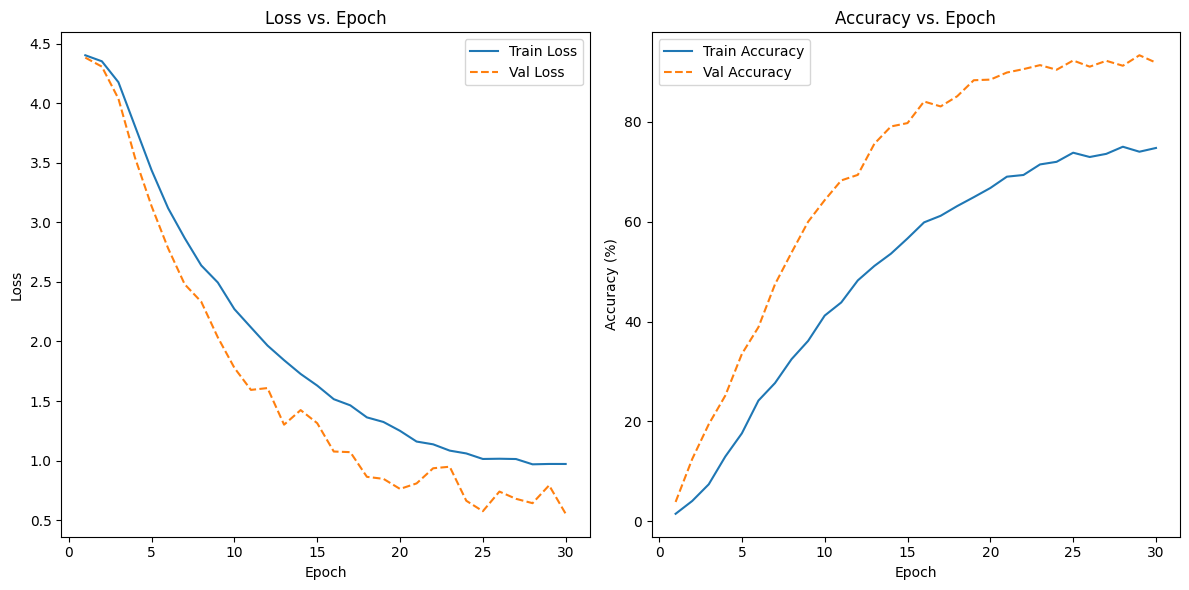

Evaluating the model...
Test Accuracy: 91.85%


In [23]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Fancy Printing
def fancy_print(message):
    print("\033[1;34m" + message + "\033[0m")


# Check GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fancy_print(f"Device: {device}")
fancy_print(f"Available GPUs: {torch.cuda.device_count()}")

# Load preprocessed data
fancy_print("Loading preprocessed data files...")
train_images = np.load('/kaggle/working/train_images.npy')
train_labels = np.load('/kaggle/working/train_labels.npy')
test_images = np.load('/kaggle/working/test_images.npy')
test_labels = np.load('/kaggle/working/test_labels.npy')

# Normalize labels
train_labels = train_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)
fancy_print("Data loaded successfully!")

# Dataset class for PyTorch
class ArabicWordDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.data_images = images
        self.data_labels = labels
        self.data_transform = transform

    def __len__(self):
        return len(self.data_images)

    def __getitem__(self, idx):
        image = self.data_images[idx]
        label = self.data_labels[idx]
        image = image.squeeze()  # Remove channel dim for grayscale

        if self.data_transform:
            image = self.data_transform(image)

        return image, label

# Define transforms
augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets and loaders
fancy_print("Preparing datasets and data loaders...")
training_dataset = ArabicWordDataset(train_images, train_labels, transform=augmentation)
testing_dataset = ArabicWordDataset(test_images, test_labels, transform=augmentation)

batch_size = 64
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

# Model definition
class ResNet101FineTuned(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101FineTuned, self).__init__()
        self.base_model = models.resnet101(weights="IMAGENET1K_V2")
        
        # Modify the first convolutional layer for grayscale images
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze all layers except the last few
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Instantiate the model and wrap it with DataParallel
num_classes = len(np.unique(train_labels))
model = ResNet101FineTuned(num_classes).to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)  # Use all available GPUs
fancy_print(f"Model initialized with ResNet101 and {num_classes} classes. Using {torch.cuda.device_count()} GPUs.")

# Training function
def train_resnet_finetuned(model, train_loader, test_loader, num_epochs=30, max_lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-4)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=num_epochs)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    train_loss_history, train_accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_preds = 0.0, 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", colour="blue"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                predictions = model(images)
                loss = criterion(predictions, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_loss += loss.item()
            correct_preds += (predictions.argmax(1) == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100.0 * correct_preds / len(train_loader.dataset)

        train_loss_history.append(avg_train_loss)
        train_accuracy_history.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    predictions = model(images)
                    loss = criterion(predictions, labels)
                    val_loss += loss.item()
                    val_correct += (predictions.argmax(1) == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = 100.0 * val_correct / len(test_loader.dataset)

        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(val_accuracy)

        fancy_print(f"Epoch {epoch+1}/{num_epochs} | "
                    f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
                    f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

# Train the model
fancy_print("Starting model training (Fine-Tuning)...")
train_losses, train_accuracies, val_losses, val_accuracies = train_resnet_finetuned(
    model, training_loader, testing_loader, num_epochs=30
)

# Plot training and validation results
fancy_print("Plotting training and validation results...")
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, 31), train_losses, label="Train Loss")
plt.plot(range(1, 31), val_losses, label="Val Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, 31), train_accuracies, label="Train Accuracy")
plt.plot(range(1, 31), val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation function
def evaluate_resnet_finetuned(model, test_loader):
    model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
            correct_predictions += (outputs.argmax(1) == labels).sum().item()

    accuracy = 100 * correct_predictions / len(test_loader.dataset)
    fancy_print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate
fancy_print("Evaluating the model...")
evaluate_resnet_finetuned(model, testing_loader)
